In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pointbiserialr
from datetime import timedelta

# Function to dynamically identify health-related columns
def identify_health_labels(df, exclude_cols=['cow', 'date', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL', 'hour']):
    potential_health_cols = [col for col in df.columns if col not in exclude_cols]
    health_labels = [col for col in potential_health_cols 
                    if df[col].dropna().isin([0, 1]).all()]
    return health_labels

c:\Users\lamia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


**Load the dataset**

In [2]:
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    return df

### **Dataset First View**

In [3]:
def display_dataset_head(df):
    return df.head()

### **Dataset Rows & Columns count**

In [4]:
def get_dataset_shape(df):
    return {'rows': df.shape[0], 'columns': df.shape[1]}

**Displaying Column Names**

In [5]:
def get_column_names(df):
    return list(df.columns)

**Define behavioral and health-related features**

In [6]:
def define_features(df):
    behavioral_features = ['IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL']
    health_indicators = identify_health_labels(df)
    return behavioral_features, health_indicators

**Distribution of health states**

In [7]:
def get_health_states_distribution(df):
    health_states = identify_health_labels(df)
    if not health_states:
        return {}
    df_health = df[health_states]
    health_counts = df_health.sum()
    total = len(df)
    health_percent = (health_counts / total * 100).to_dict()
    return health_percent

def plot_health_states_distribution(df):
    health_states = identify_health_labels(df)
    if not health_states:
        print("No health states identified in the dataset.")
        return
    df_health = df[health_states]
    health_counts = df_health.sum().sort_values(ascending=False)
    total = len(df)
    health_percent = (health_counts / total) * 100

    safe_health_percent = health_percent.copy()
    safe_health_percent[safe_health_percent == 0] = 0.01

    plt.figure(figsize=(12, 6))
    bars = plt.bar(safe_health_percent.index, safe_health_percent.values, color='lightcoral')

    for i, bar in enumerate(bars):
        original = health_percent.values[i]
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                 f'{original:.2f}%', ha='center', va='bottom')

    plt.yscale('log')
    plt.title('Proportion of Health States (Log Scale)', fontweight='bold')
    plt.xlabel('Health States', fontweight='bold')
    plt.ylabel('Percentage (log scale)', fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7, which='both')
    plt.tight_layout()
    plt.show()

**Unique Value Counts per Event**

In [8]:
def get_unique_value_counts(df):
    target_columns = identify_health_labels(df)
    value_counts_dict = {}
    for col in target_columns:
        value_counts = df[col].value_counts().to_dict()
        value_counts_dict[col] = value_counts
    return value_counts_dict

**Count the number of cows in the dataset**

In [9]:
def count_unique_cows(df):
    return df['cow'].nunique()

**Display the ids of cows**

In [10]:
def get_cow_ids(df):
    unique_cow_ids = df['cow'].unique()
    sorted_cow_ids = sorted(unique_cow_ids)
    return sorted_cow_ids

**Duplicate Values**

In [11]:
def check_duplicates(df):
    return df.duplicated().sum()

**Missing Values**

In [12]:
def check_missing_values(df):
    return df.isnull().sum().to_dict()

**Matrix of missing values**

In [13]:
def plot_missing_values_matrix(file_path):
    data = pd.read_csv(file_path)
    plt.figure(figsize=(15, 8))
    msno.matrix(data, color=(0, 0.5, 0.5))
    plt.title("Matrice des valeurs manquantes", fontsize=18, fontweight='bold')
    plt.show()

**Outliers detection**

Détails du calcul théorique :

1. Plage minimale ( -828 ) :

Si une vache passe 1 heure entière (3600 secondes) au repos : -0.23 * 3600 + 0.16 * 0 + 0.42 * 0 = -828

2. Plage maximale ( 1512 ) :

Si une vache passe 1 heure entière (3600 secondes) à manger : -0.23 * 0 + 0.16 * 0 + 0.42 * 3600 = 1512

In [14]:
def detect_and_plot_outliers(df):
    min_theorique = -828
    max_theorique = 1512

    min_obs = df['ACTIVITY_LEVEL'].min()
    max_obs = df['ACTIVITY_LEVEL'].max()

    outliers = df[(df['ACTIVITY_LEVEL'] < min_theorique) | (df['ACTIVITY_LEVEL'] > max_theorique)]
    num_outliers = len(outliers)

    plt.figure(figsize=(10, 6))
    plt.hist(df['ACTIVITY_LEVEL'], bins=50, color='skyblue', edgecolor='black')
    plt.axvline(x=min_theorique, color='red', linestyle='--', label='Borne min théorique')
    plt.axvline(x=max_theorique, color='green', linestyle='--', label='Borne max théorique')
    plt.xlabel('Niveau d\'activité')
    plt.ylabel('Fréquence')
    plt.title('Distribution des niveaux d\'activité')
    plt.legend()
    plt.xlim(-1000, 1600)
    plt.show()

    return {'num_outliers': num_outliers, 'percent_outliers': num_outliers/len(df)*100, 'min_obs': min_obs, 'max_obs': max_obs}

In [15]:
def plot_histograms(df):
    cols = ['IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL']
    df[cols].hist(bins=20, figsize=(12, 10))
    plt.suptitle("Data Distribution")
    plt.show()

**Visualization of Health States Proportions**

In [16]:
def plot_health_states_proportions(file_path):
    df = pd.read_csv(file_path)
    health_states = identify_health_labels(df)
    if not health_states:
        print("No health states identified in the dataset.")
        return

    df_health = df[health_states]
    health_counts = df_health.sum().sort_values(ascending=False)
    total = len(df)
    health_percent = (health_counts / total) * 100

    plt.figure(figsize=(12, 6))
    bars = plt.bar(health_percent.index, health_percent.values, color='lightcoral')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%', ha='center', va='bottom')

    plt.title('Proportion of Health States (in %)', fontweight='bold')
    plt.xlabel('Health States', fontweight='bold')
    plt.ylabel('Percentage', fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

**Missing hours**

In [17]:
def get_missing_hours(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    obs_counts = df.groupby(['cow', 'date']).size().reset_index(name='hour_count')
    missing_obs = obs_counts[obs_counts['hour_count'] < 24]
    missing_hours = missing_obs.groupby('cow')['hour_count'].apply(lambda x: (24 - x).sum()).to_dict()
    total_missing = sum(missing_hours.values())

    plt.figure(figsize=(12, 6))
    missing_obs.groupby('cow')['hour_count'].apply(lambda x: (24 - x).sum()).sort_values(ascending=False).plot(kind='bar')
    plt.title("Total Missing Hours per Cow (only cows with missing 24h records)")
    plt.xlabel("Cow ID")
    plt.ylabel("Total Missing Hours")
    plt.tight_layout()
    plt.show()

    return {'total_missing_hours': total_missing, 'cows_with_missing': len(missing_hours), 'missing_hours_per_cow': missing_hours}

**Check Date Range and Missing Dates**

In [18]:
def check_date_range(df):
    df['date'] = pd.to_datetime(df['date'])
    min_date = df['date'].min()
    max_date = df['date'].max()
    all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
    missing_dates = all_dates.difference(df['date'].dt.date.unique())
    return {'min_date': min_date, 'max_date': max_date, 'total_days': len(all_dates), 'missing_dates_count': len(missing_dates)}

**Analysis of Cows with Multiple Diseases**

In [19]:
def analyze_multiple_diseases(df):
    maladie_cols = [col for col in identify_health_labels(df) if col != 'OK']
    if not maladie_cols:
        return {'multiple_disease_cases': 0}

    df_non_ok = df[df['OK'] == 0].copy()
    df_non_ok['nb_maladies'] = df_non_ok[maladie_cols].sum(axis=1)
    multi_maladie = df_non_ok[df_non_ok['nb_maladies'] > 1].copy()

    return {'multiple_disease_cases': len(multi_maladie)}

In [20]:
# Function to create summary tables
def create_summary_tables(summary_data):
    # Dataset Shape Table
    shape_df = pd.DataFrame({
        'Dataset': [d['name'] for d in summary_data],
        'Rows': [d['shape']['rows'] for d in summary_data],
        'Columns': [d['shape']['columns'] for d in summary_data]
    })

    # Unique Cows and Missing Hours Table
    cows_df = pd.DataFrame({
        'Dataset': [d['name'] for d in summary_data],
        'Unique Cows': [d['unique_cows'] for d in summary_data],
        'Cows with Missing Hours': [d['missing_hours']['cows_with_missing'] for d in summary_data],
        'Total Missing Hours': [d['missing_hours']['total_missing_hours'] for d in summary_data]
    })

    # Missing Values Table
    missing_values = {}
    for d in summary_data:
        for col, count in d['missing_values'].items():
            if col not in missing_values:
                missing_values[col] = {d['name']: count}
            else:
                missing_values[col][d['name']] = count
    missing_df = pd.DataFrame(missing_values).fillna(0).astype(int).T

    # Health States Distribution Table
    health_states = {}
    for d in summary_data:
        for state, percent in d['health_distribution'].items():
            if state not in health_states:
                health_states[state] = {d['name']: f'{percent:.2f}%'}
            else:
                health_states[state][d['name']] = f'{percent:.2f}%'
    health_df = pd.DataFrame(health_states).fillna('0.00%').T

    # Outliers and Date Range Table
    outliers_df = pd.DataFrame({
        'Dataset': [d['name'] for d in summary_data],
        'Outliers Count': [d['outliers']['num_outliers'] for d in summary_data],
        'Outliers %': [f'{d["outliers"]["percent_outliers"]:.2f}%' for d in summary_data],
        'Min Activity': [f'{d["outliers"]["min_obs"]:.2f}' for d in summary_data],
        'Max Activity': [f'{d["outliers"]["max_obs"]:.2f}' for d in summary_data],
        'Min Date': [d['date_range']['min_date'].strftime('%Y-%m-%d') for d in summary_data],
        'Max Date': [d['date_range']['max_date'].strftime('%Y-%m-%d') for d in summary_data],
        'Total Days': [d['date_range']['total_days'] for d in summary_data],
        'Missing Dates': [d['date_range']['missing_dates_count'] for d in summary_data]
    })

    return shape_df, cows_df, missing_df, health_df, outliers_df


Analyzing C:/Users/lamia/Desktop/datasets/dataset1.csv

Dataset First View:


,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,6601,2018-10-25,11,1603.585,1355.386,41.024,-37.93510,0,0,0,0,0,NaN,0,0,0,0,0,1
1,6601,2018-10-25,12,1586.965,138.501,1874.528,1009.36093,0,0,0,0,0,NaN,0,0,0,0,0,1
2,6601,2018-10-25,13,1442.930,567.066,1584.866,766.08734,0,0,0,0,0,NaN,0,0,0,0,0,1
3,6601,2018-10-25,14,209.571,2728.410,662.013,-315.95748,0,0,0,0,0,NaN,0,0,0,0,0,1
4,6601,2018-10-25,15,1094.275,298.497,2207.222,1033.46293,0,0,0,0,0,NaN,0,0,0,0,0,1



Dataset Rows & Columns count:
Number of rows: 107665
Number of columns: 19

Column Names:
['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL', 'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis', 'other_disease', 'accidents', 'disturbance', 'mixing', 'management_changes', 'OK']

Distribution of Health States:


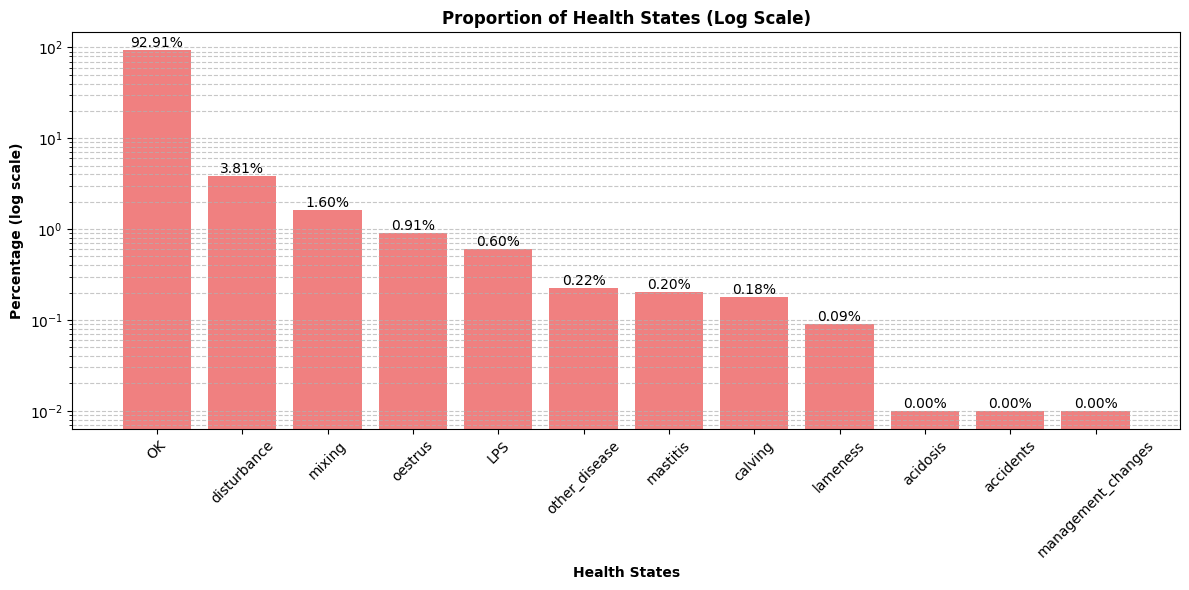


Unique Value Counts per Event:
oestrus:
{0: 106681, 1: 984}
---------------------------------
calving:
{0: 107473, 1: 192}
---------------------------------
lameness:
{0: 107569, 1: 96}
---------------------------------
mastitis:
{0: 107449, 1: 216}
---------------------------------
LPS:
{0: 107017, 1: 648}
---------------------------------
acidosis:
{}
---------------------------------
other_disease:
{0: 107425, 1: 240}
---------------------------------
accidents:
{0: 107665}
---------------------------------
disturbance:
{0: 103559, 1: 4106}
---------------------------------
mixing:
{0: 105937, 1: 1728}
---------------------------------
management_changes:
{0: 107665}
---------------------------------
OK:
{1: 100031, 0: 7634}
---------------------------------

Number of Unique Cows:
Total number of unique cows: 28

Cow IDs:
Sorted list of cow IDs: [6601, 6610, 6612, 6613, 6621, 6629, 6633, 6634, 6637, 6638, 6643, 6646, 6656, 6664, 6674, 6675, 6683, 6686, 6689, 6690, 6693, 6695, 6699

<Figure size 1500x800 with 0 Axes>

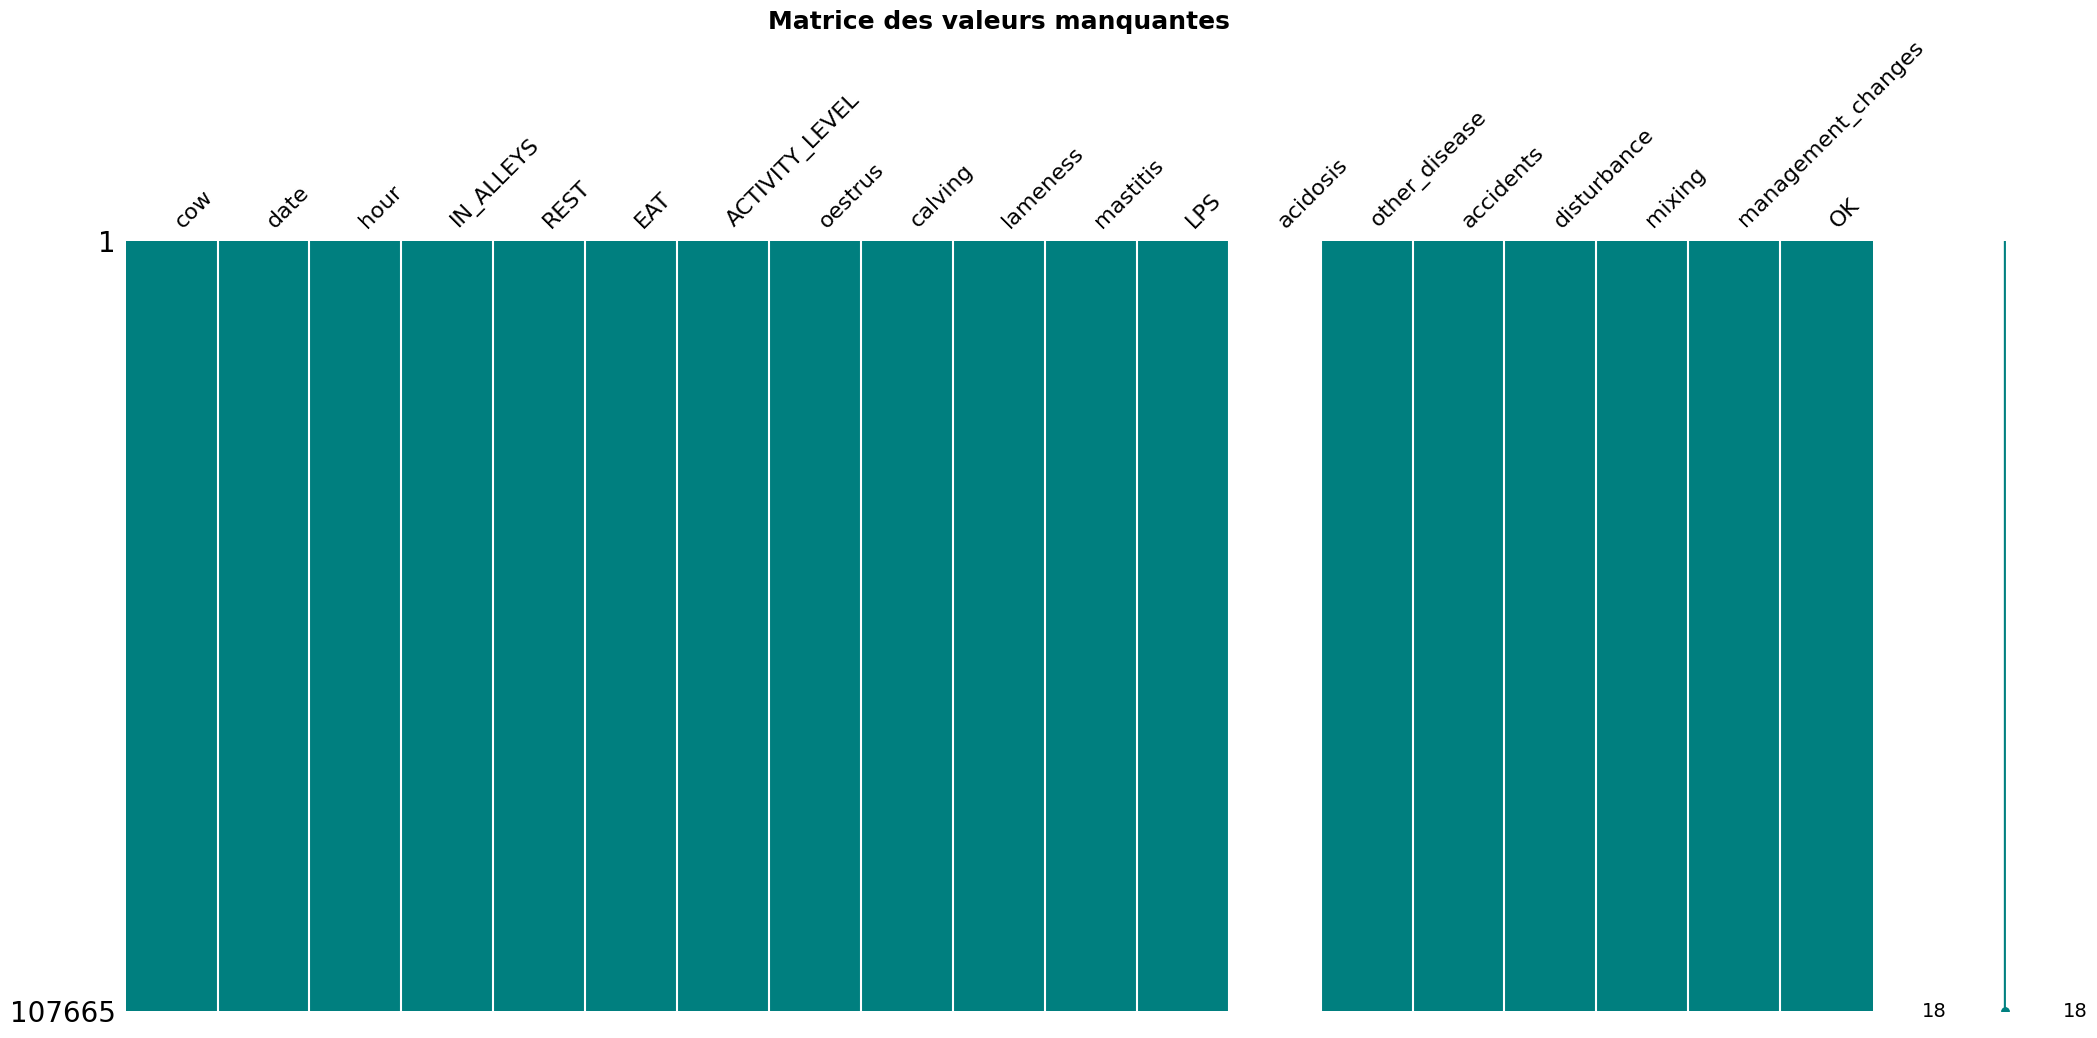


Outliers Detection:


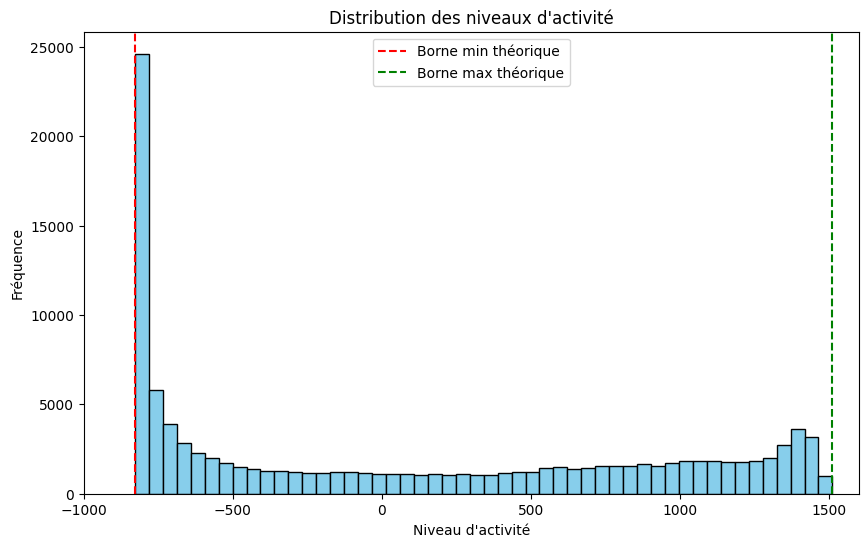

Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]
- Valeurs hors plage théorique : 0 (0.00% du dataset)

Data Distribution Histograms:


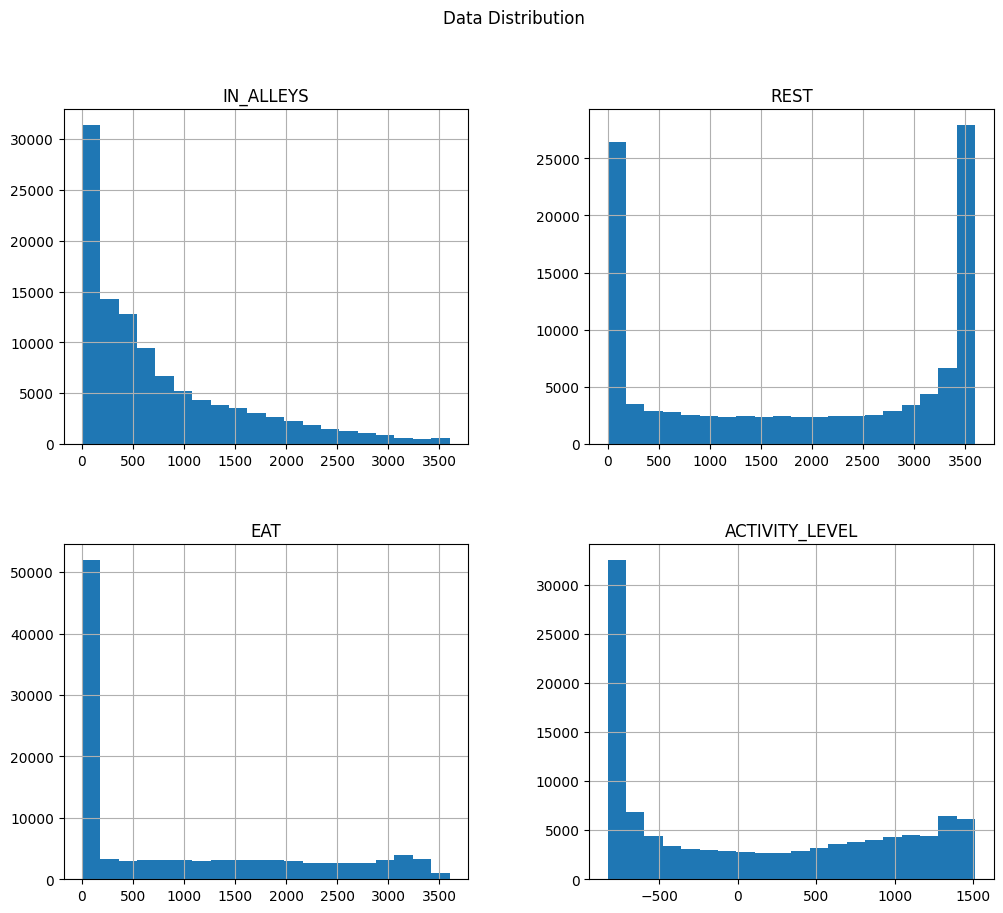


Health States Proportions:


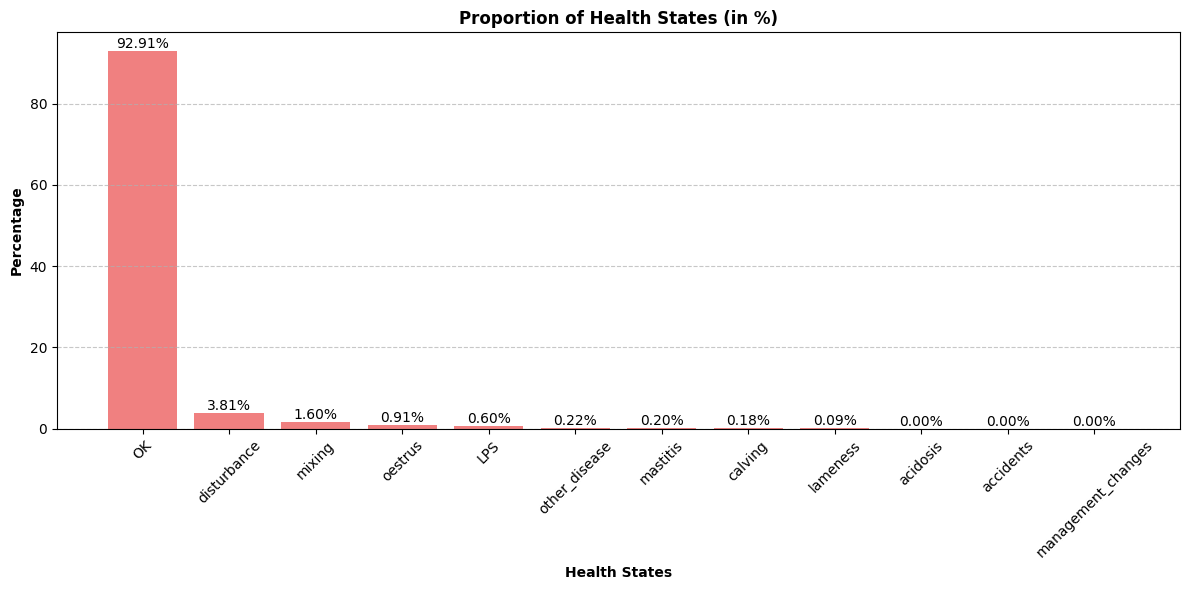


Missing Hours:


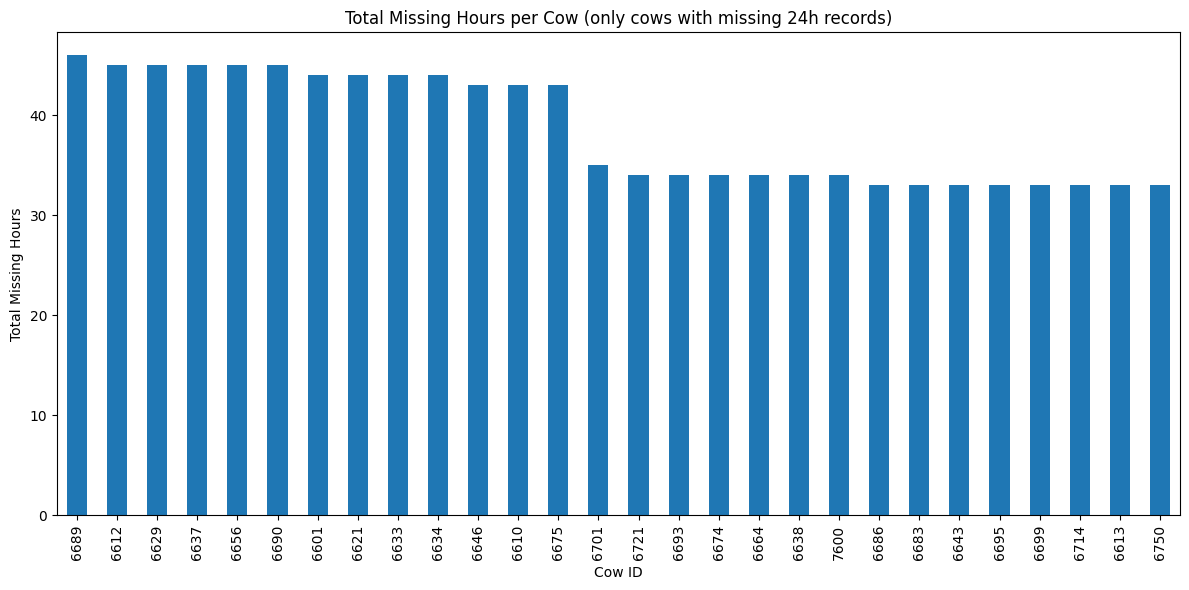


Date Range and Missing Dates:
Date range: 2018-10-25 00:00:00 to 2019-04-17 00:00:00
Total expected days: 175
Missing dates (3): 2019-01-25, 2019-01-26, 2019-01-27

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 528

Analyzing C:/Users/lamia/Desktop/datasets/dataset2.csv

Dataset First View:


,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,7163,2015-03-02,1,185.517,3414.482,0.0,-755.64814,0,0,0,0,NaN,0,0,0,1,0,0,0
1,7163,2015-03-02,2,0.000,3599.999,0.0,-827.99977,0,0,0,0,NaN,0,0,0,1,0,0,0
2,7163,2015-03-02,3,10.661,3589.338,0.0,-823.84198,0,0,0,0,NaN,0,0,0,1,0,0,0
3,7163,2015-03-02,4,43.800,3556.199,0.0,-810.91777,0,0,0,0,NaN,0,0,0,1,0,0,0
4,7163,2015-03-02,5,17.167,3582.832,0.0,-821.30464,0,0,0,0,NaN,0,0,0,1,0,0,0



Dataset Rows & Columns count:
Number of rows: 40247
Number of columns: 19

Column Names:
['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL', 'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis', 'other_disease', 'accidents', 'disturbance', 'mixing', 'management_changes', 'OK']

Distribution of Health States:


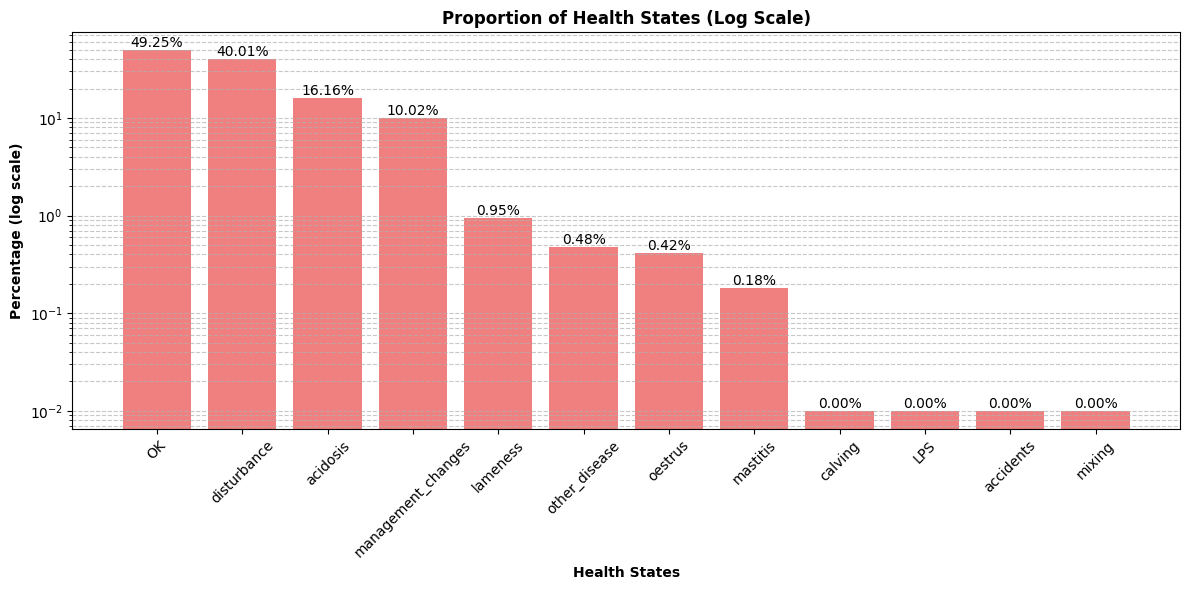


Unique Value Counts per Event:
oestrus:
{0: 40079, 1: 168}
---------------------------------
calving:
{0: 40247}
---------------------------------
lameness:
{0: 39863, 1: 384}
---------------------------------
mastitis:
{0: 40175, 1: 72}
---------------------------------
LPS:
{}
---------------------------------
acidosis:
{0: 33743, 1: 6504}
---------------------------------
other_disease:
{0: 40055, 1: 192}
---------------------------------
accidents:
{0: 40247}
---------------------------------
disturbance:
{0: 24143, 1: 16104}
---------------------------------
mixing:
{0: 40247}
---------------------------------
management_changes:
{0: 36215, 1: 4032}
---------------------------------
OK:
{0: 20424, 1: 19823}
---------------------------------

Number of Unique Cows:
Total number of unique cows: 28

Cow IDs:
Sorted list of cow IDs: [151, 153, 156, 162, 173, 189, 1177, 1624, 2152, 2155, 2158, 2162, 2164, 2165, 2170, 2175, 2179, 2182, 2183, 2185, 2187, 2603, 2622, 7163, 8200, 8605, 86

<Figure size 1500x800 with 0 Axes>

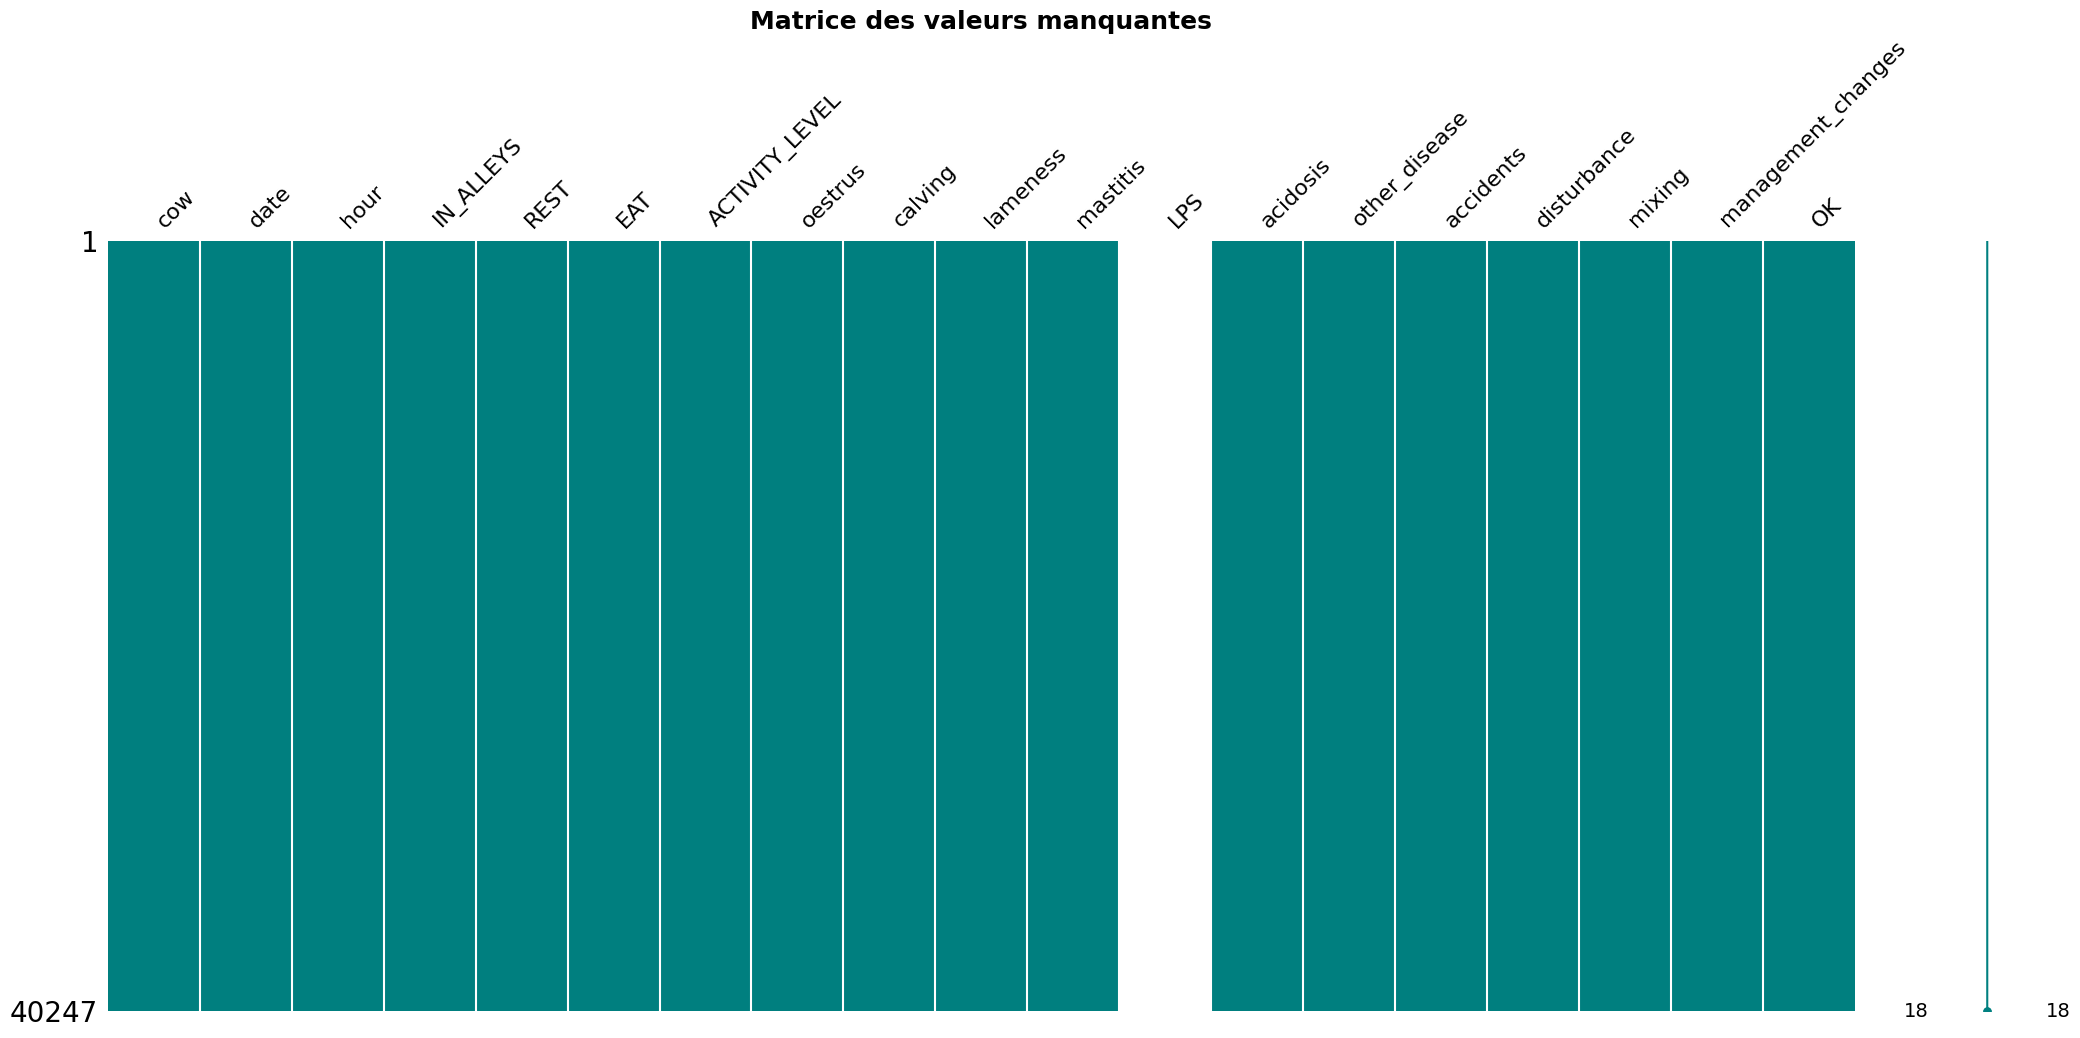


Outliers Detection:


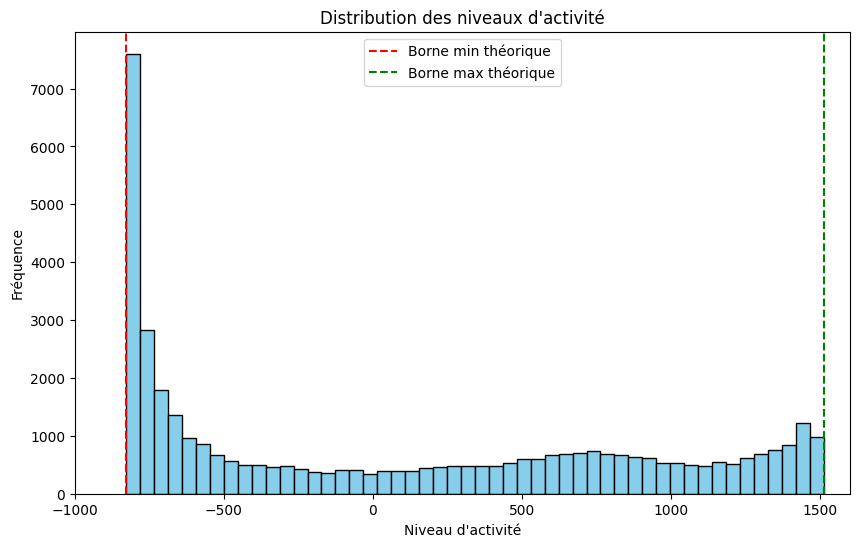

Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]
- Valeurs hors plage théorique : 0 (0.00% du dataset)

Data Distribution Histograms:


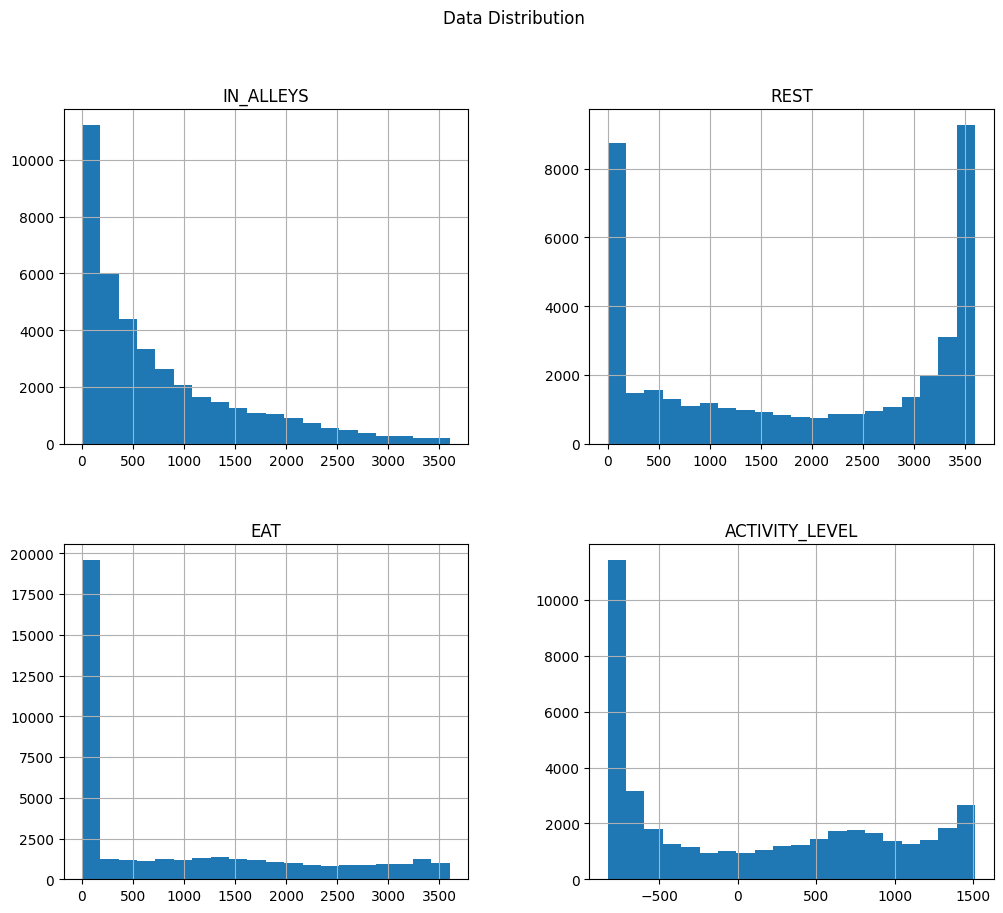


Health States Proportions:


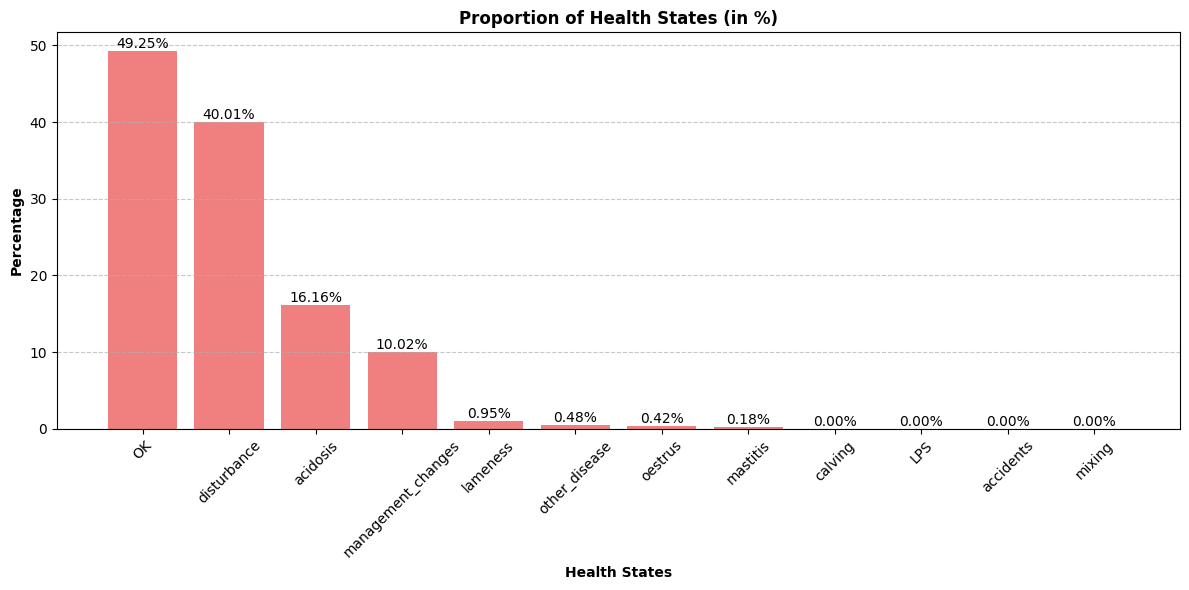


Missing Hours:


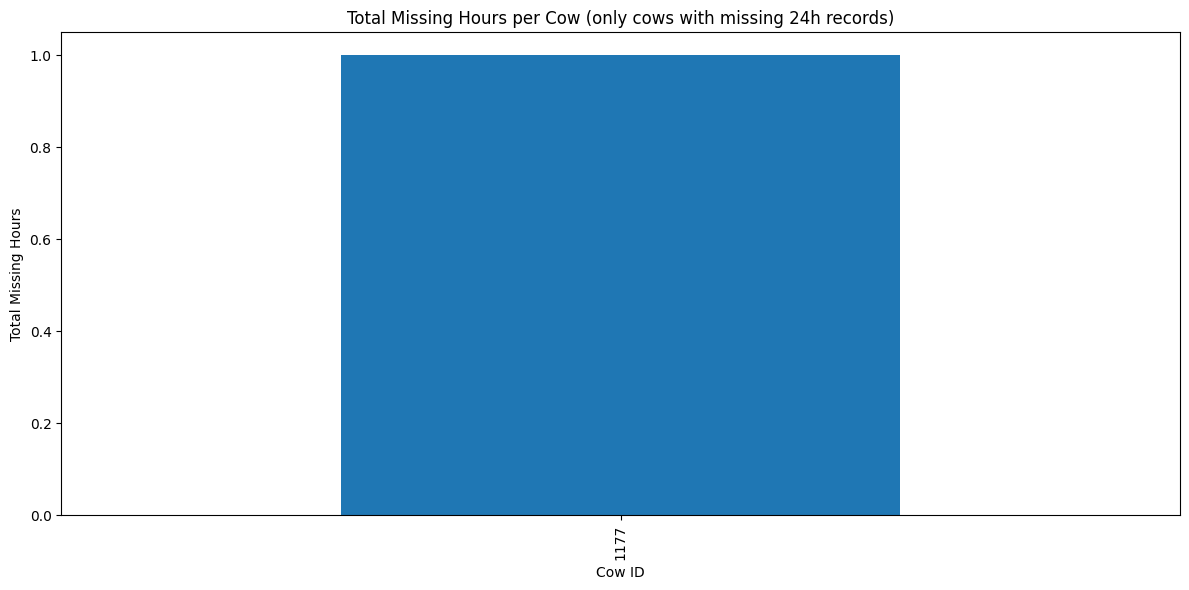


Date Range and Missing Dates:
Date range: 2015-03-02 00:00:00 to 2015-04-30 00:00:00
Total expected days: 60
Missing dates (0): 

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 4776

Analyzing C:/Users/lamia/Desktop/datasets/dataset3.csv

Dataset First View:


,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,10127,2013-10-01,1,0.000,3600.000,0.000,-828.00000,0,0,0,0,NaN,NaN,0,0,0,0,0,1
1,10127,2013-10-01,2,2931.783,444.528,223.689,460.79322,0,0,0,0,NaN,NaN,0,0,0,0,0,1
2,10127,2013-10-01,3,257.740,2930.966,411.294,-460.14030,0,0,0,0,NaN,NaN,0,0,0,0,0,1
3,10127,2013-10-01,4,63.220,3536.780,0.000,-803.34420,0,0,0,0,NaN,NaN,0,0,0,0,0,1
4,10127,2013-10-01,5,0.000,3600.000,0.000,-828.00000,0,0,0,0,NaN,NaN,0,0,0,0,0,1



Dataset Rows & Columns count:
Number of rows: 26225
Number of columns: 19

Column Names:
['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL', 'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis', 'other_disease', 'accidents', 'disturbance', 'mixing', 'management_changes', 'OK']

Distribution of Health States:


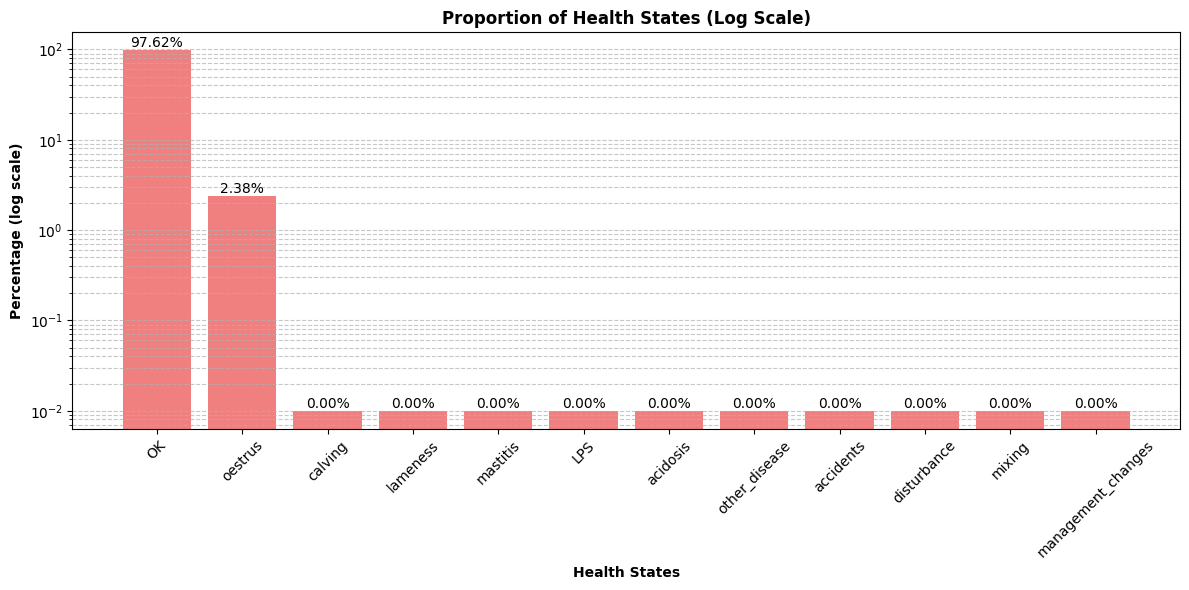


Unique Value Counts per Event:
oestrus:
{0: 25601, 1: 624}
---------------------------------
calving:
{0: 26225}
---------------------------------
lameness:
{0: 26225}
---------------------------------
mastitis:
{0: 26225}
---------------------------------
LPS:
{}
---------------------------------
acidosis:
{}
---------------------------------
other_disease:
{0: 26225}
---------------------------------
accidents:
{0: 26225}
---------------------------------
disturbance:
{0: 26225}
---------------------------------
mixing:
{0: 26225}
---------------------------------
management_changes:
{0: 26225}
---------------------------------
OK:
{1: 25601, 0: 624}
---------------------------------

Number of Unique Cows:
Total number of unique cows: 30

Cow IDs:
Sorted list of cow IDs: [1565, 1797, 1919, 2284, 2340, 2395, 2399, 2576, 2581, 2699, 4102, 4262, 4279, 4372, 4495, 4716, 5098, 5104, 5128, 5394, 5541, 5810, 5896, 8595, 9481, 9502, 9601, 9994, 10127, 10567]

Duplicate Values:
Number of du

<Figure size 1500x800 with 0 Axes>

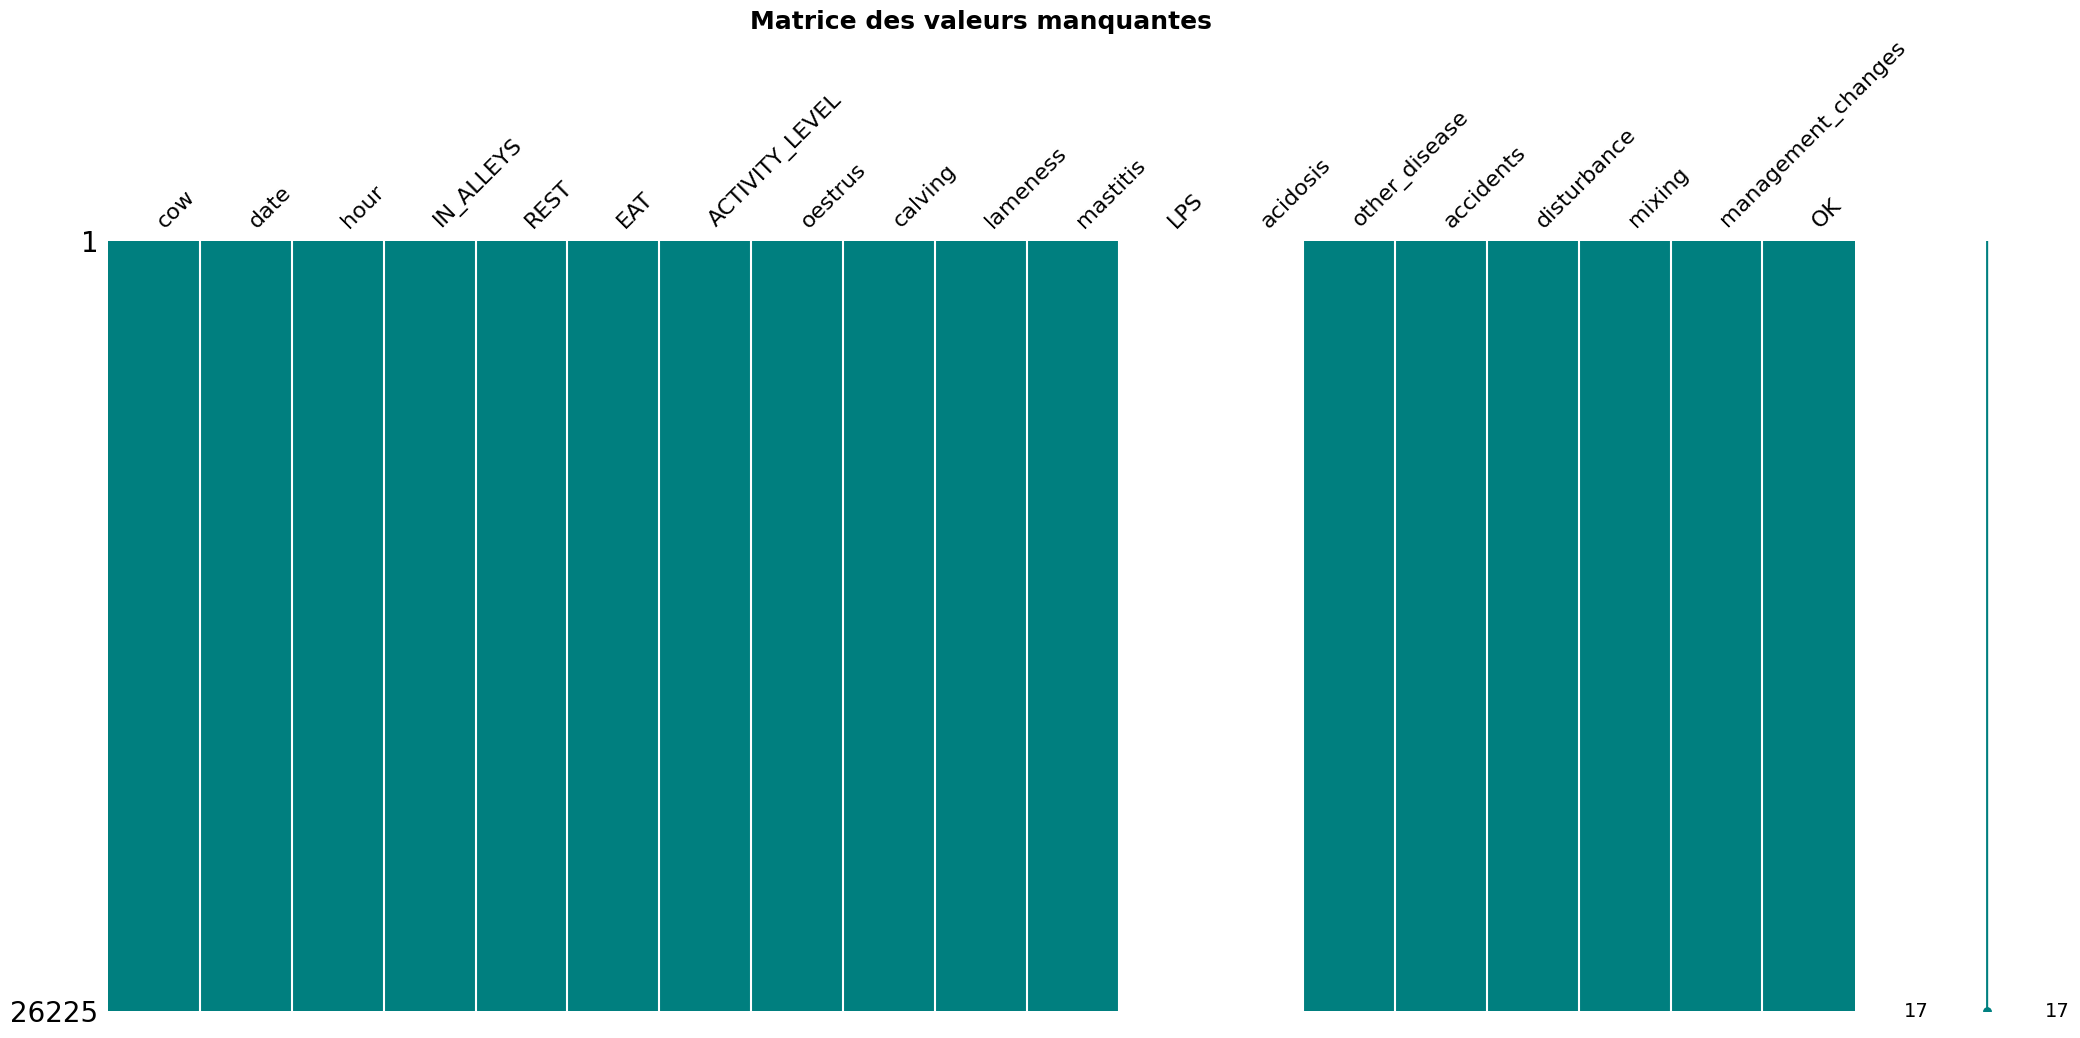


Outliers Detection:


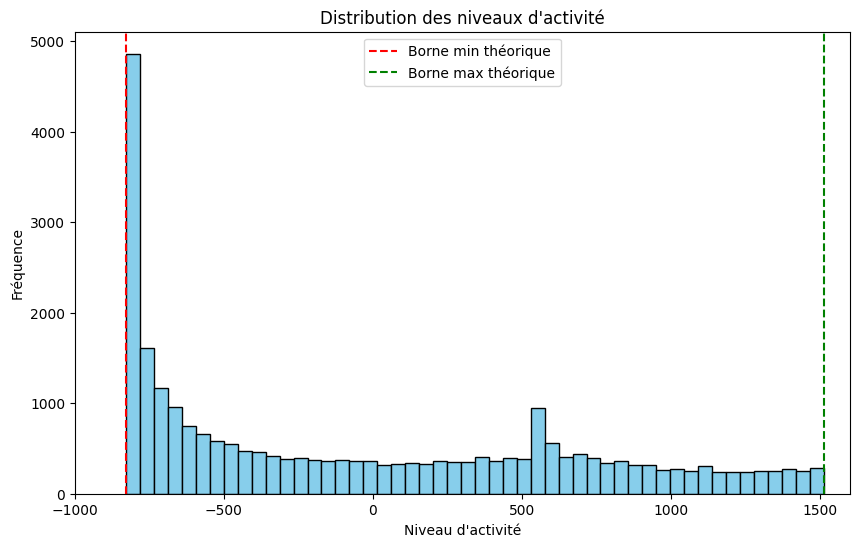

Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]
- Valeurs hors plage théorique : 0 (0.00% du dataset)

Data Distribution Histograms:


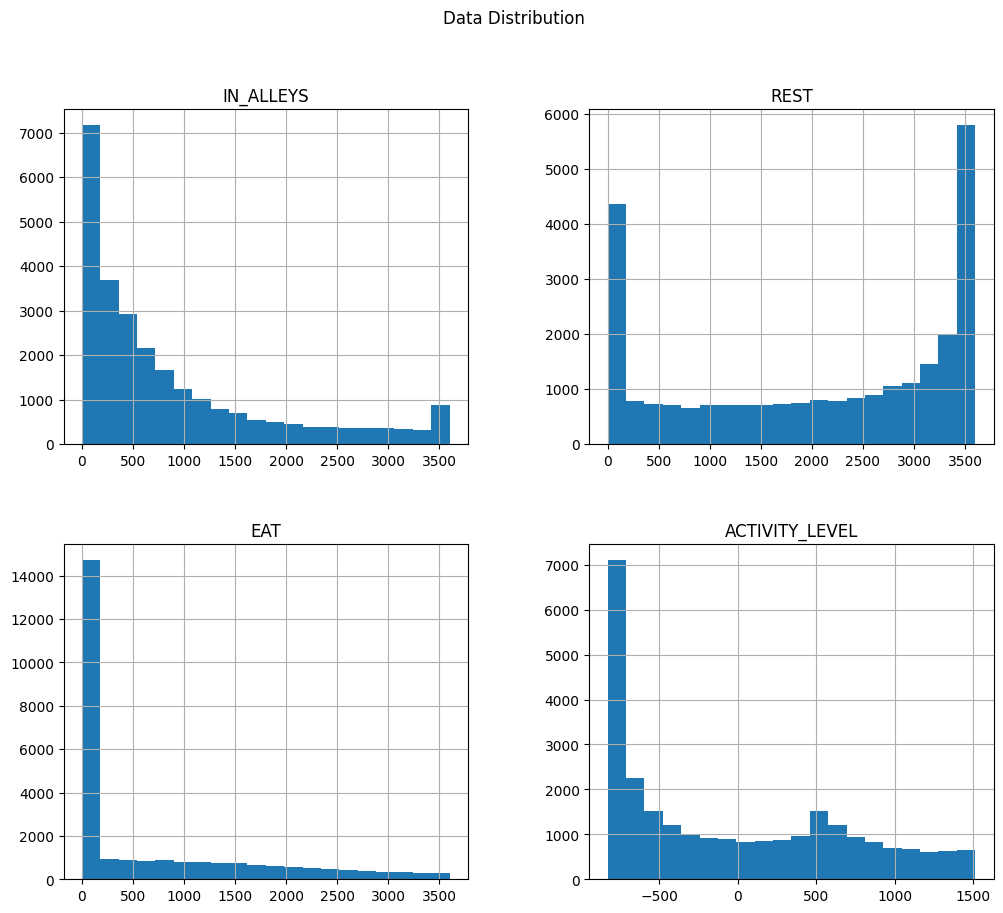


Health States Proportions:


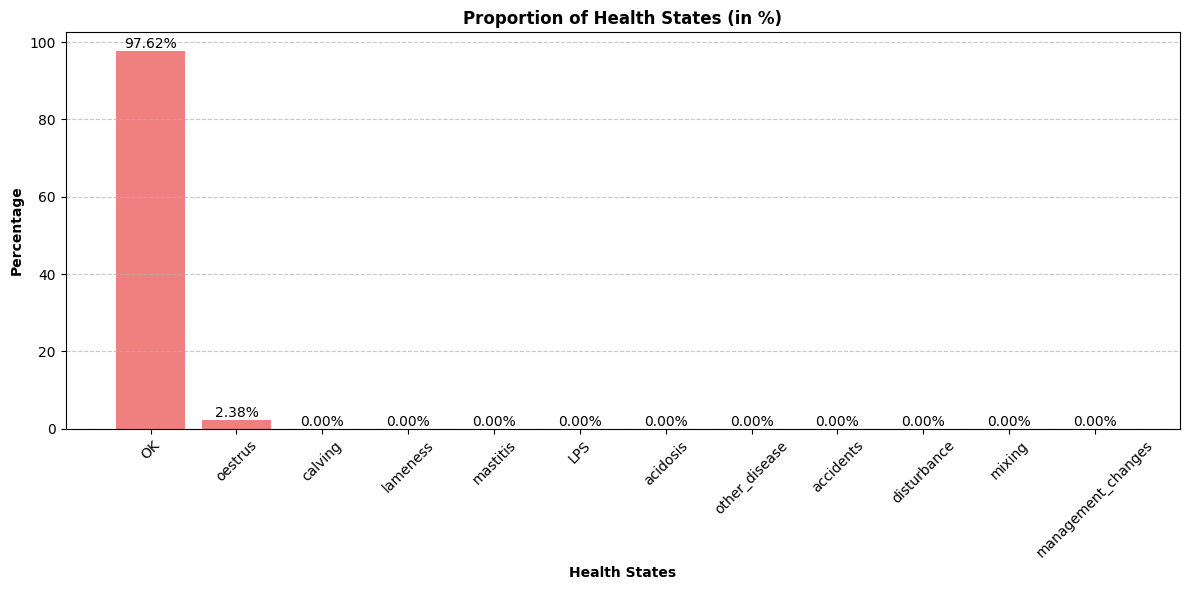


Missing Hours:


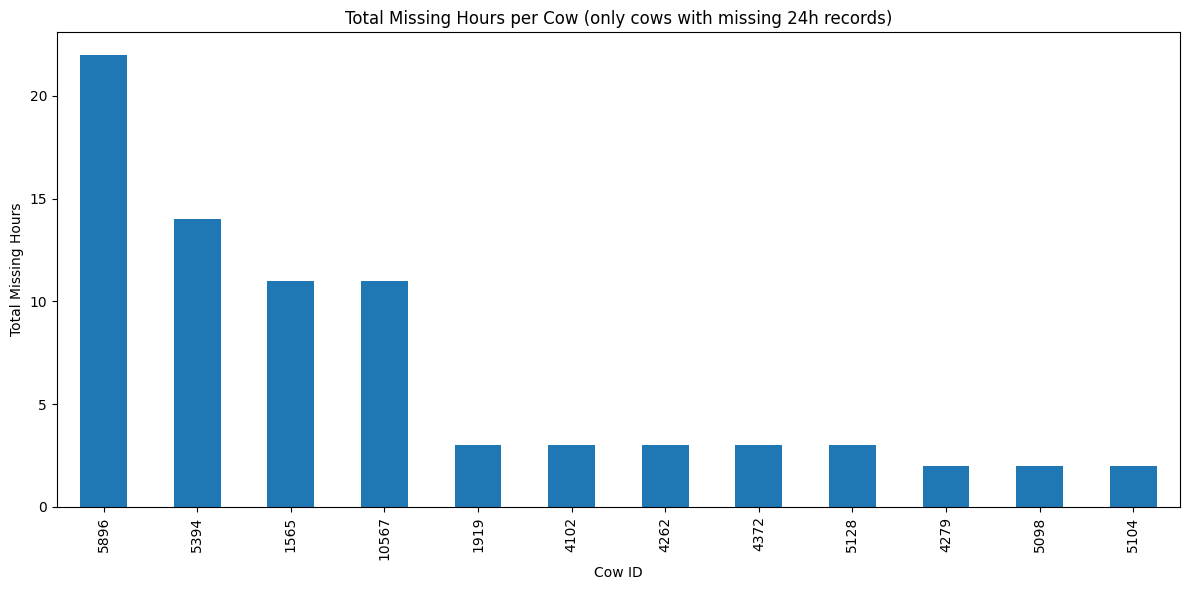


Date Range and Missing Dates:
Date range: 2013-10-01 00:00:00 to 2013-11-11 00:00:00
Total expected days: 42
Missing dates (0): 

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 0

Analyzing C:/Users/lamia/Desktop/datasets/dataset4_truncated.csv

Dataset First View:


,cow,date,hour,IN_ALLEYS,REST,EAT,ACTIVITY_LEVEL,oestrus,calving,lameness,mastitis,LPS,acidosis,other_disease,accidents,disturbance,mixing,management_changes,OK
0,35687,2014-12-01,1,268.600,3288.426,42.973,-695.31332,0,0,0,0,NaN,NaN,0,0,0,0,0,1
1,35687,2014-12-01,2,169.599,3430.400,0.000,-761.85616,0,0,0,0,NaN,NaN,0,0,0,0,0,1
2,35687,2014-12-01,3,35.068,3564.931,0.000,-814.32325,0,0,0,0,NaN,NaN,0,0,0,0,0,1
3,35687,2014-12-01,4,0.000,3599.999,0.000,-827.99977,0,0,0,0,NaN,NaN,0,0,0,0,0,1
4,35687,2014-12-01,5,207.026,3392.973,0.000,-747.25963,0,0,0,0,NaN,NaN,0,0,0,0,0,1



Dataset Rows & Columns count:
Number of rows: 179759
Number of columns: 19

Column Names:
['cow', 'date', 'hour', 'IN_ALLEYS', 'REST', 'EAT', 'ACTIVITY_LEVEL', 'oestrus', 'calving', 'lameness', 'mastitis', 'LPS', 'acidosis', 'other_disease', 'accidents', 'disturbance', 'mixing', 'management_changes', 'OK']

Distribution of Health States:


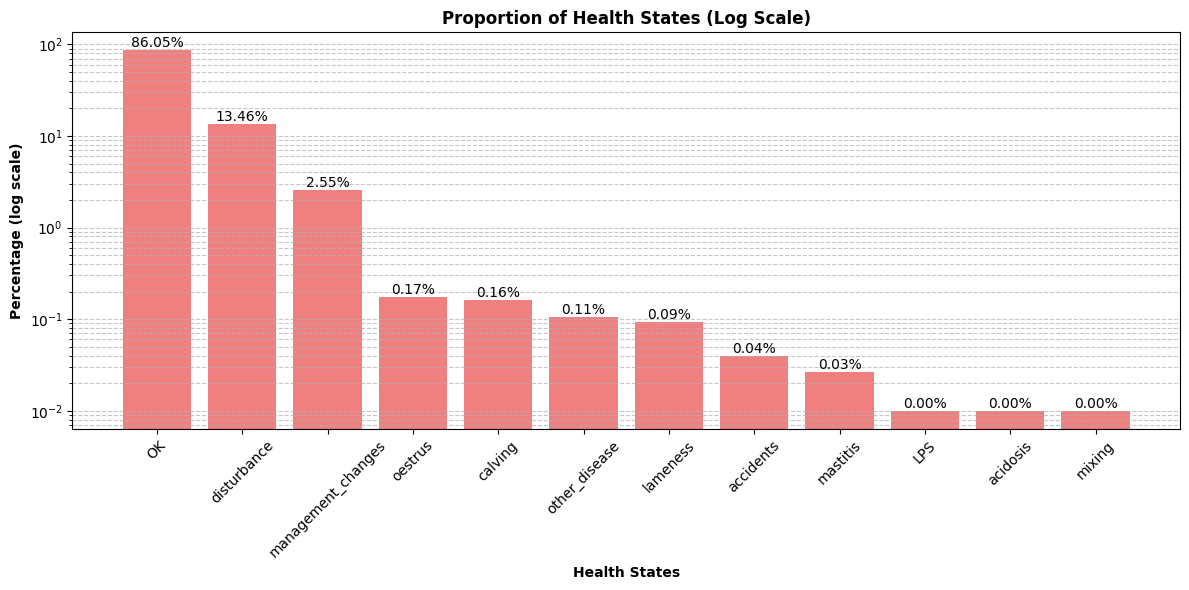


Unique Value Counts per Event:
oestrus:
{0: 179447, 1: 312}
---------------------------------
calving:
{0: 179471, 1: 288}
---------------------------------
lameness:
{0: 179591, 1: 168}
---------------------------------
mastitis:
{0: 179711, 1: 48}
---------------------------------
LPS:
{}
---------------------------------
acidosis:
{}
---------------------------------
other_disease:
{0: 179567, 1: 192}
---------------------------------
accidents:
{0: 179687, 1: 72}
---------------------------------
disturbance:
{0: 155567, 1: 24192}
---------------------------------
mixing:
{0: 179759}
---------------------------------
management_changes:
{0: 175175, 1: 4584}
---------------------------------
OK:
{1: 154679, 0: 25080}
---------------------------------

Number of Unique Cows:
Total number of unique cows: 25

Cow IDs:
Sorted list of cow IDs: [35687, 42599, 44432, 45683, 46649, 47875, 47899, 48094, 48133, 48492, 48500, 48531, 48555, 48589, 48599, 48642, 49097, 49108, 49149, 49230, 4937

<Figure size 1500x800 with 0 Axes>

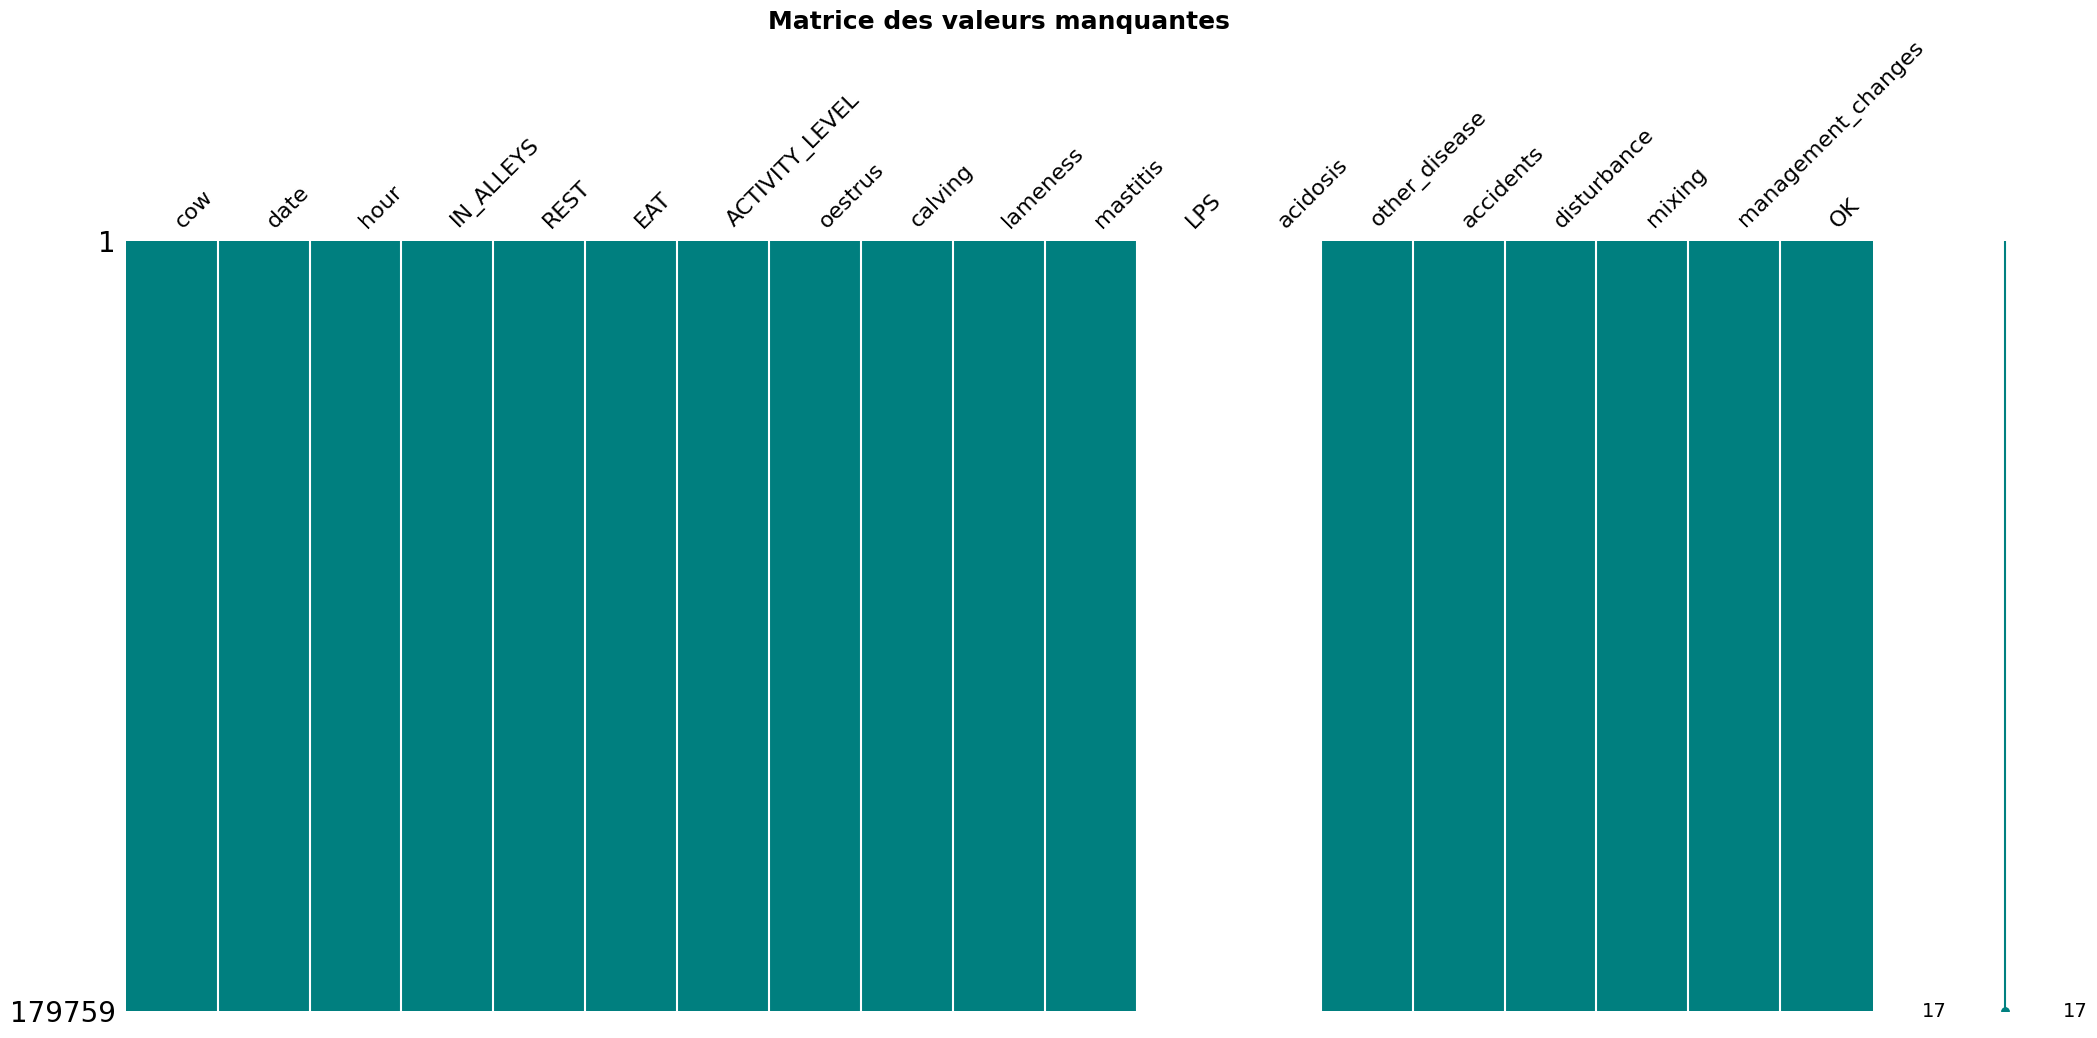


Outliers Detection:


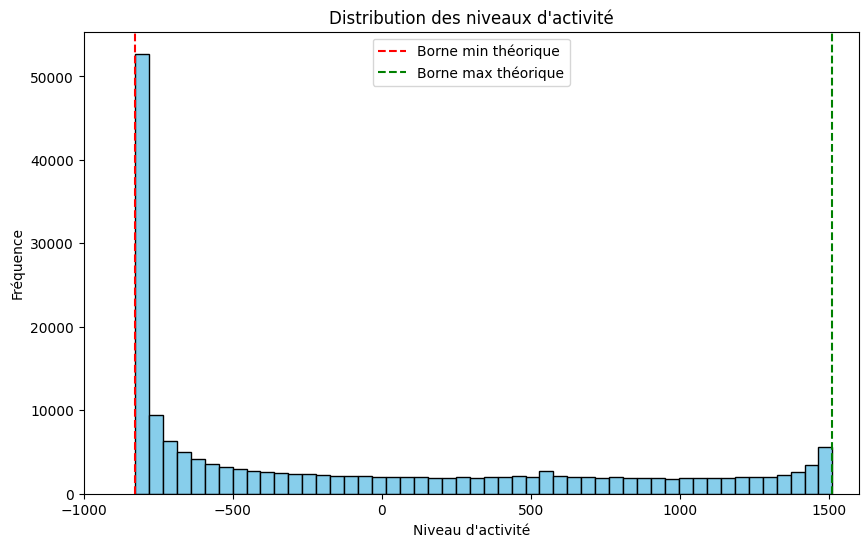

Plage théorique : [-828, 1512]
Plage observée  : [-828.00, 1512.00]
- Valeurs hors plage théorique : 0 (0.00% du dataset)

Data Distribution Histograms:


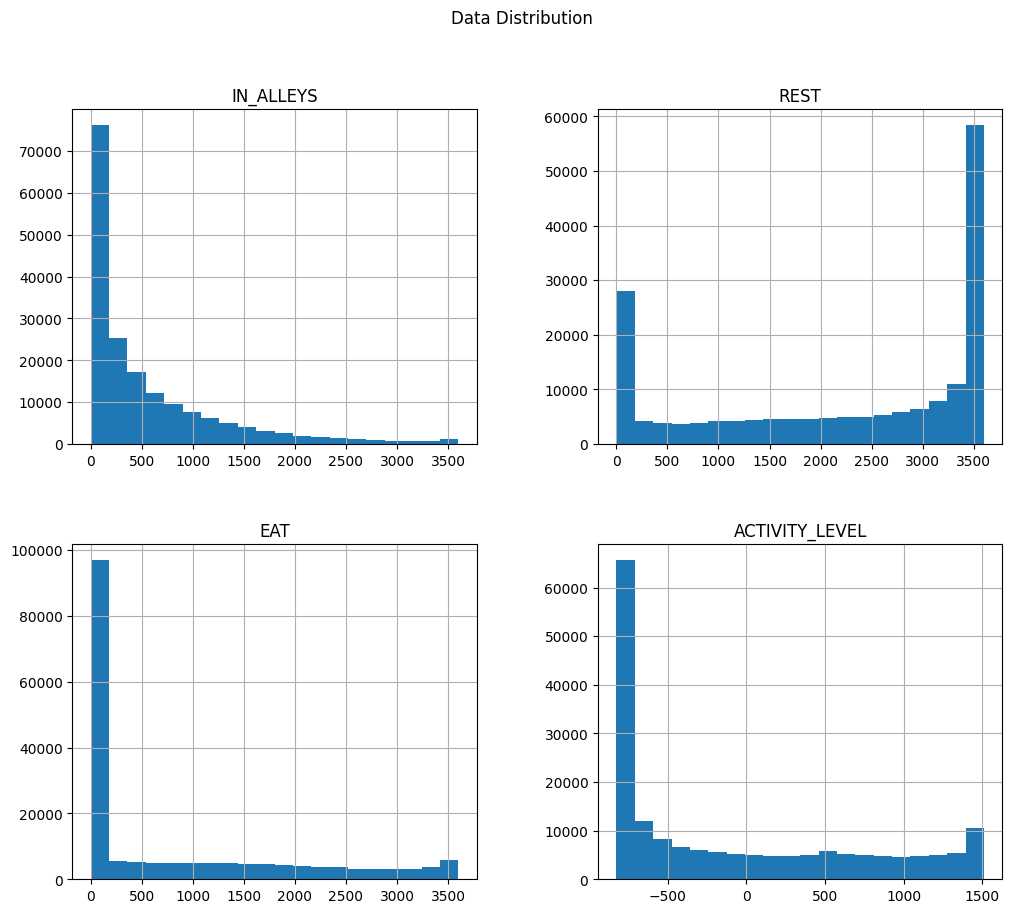


Health States Proportions:


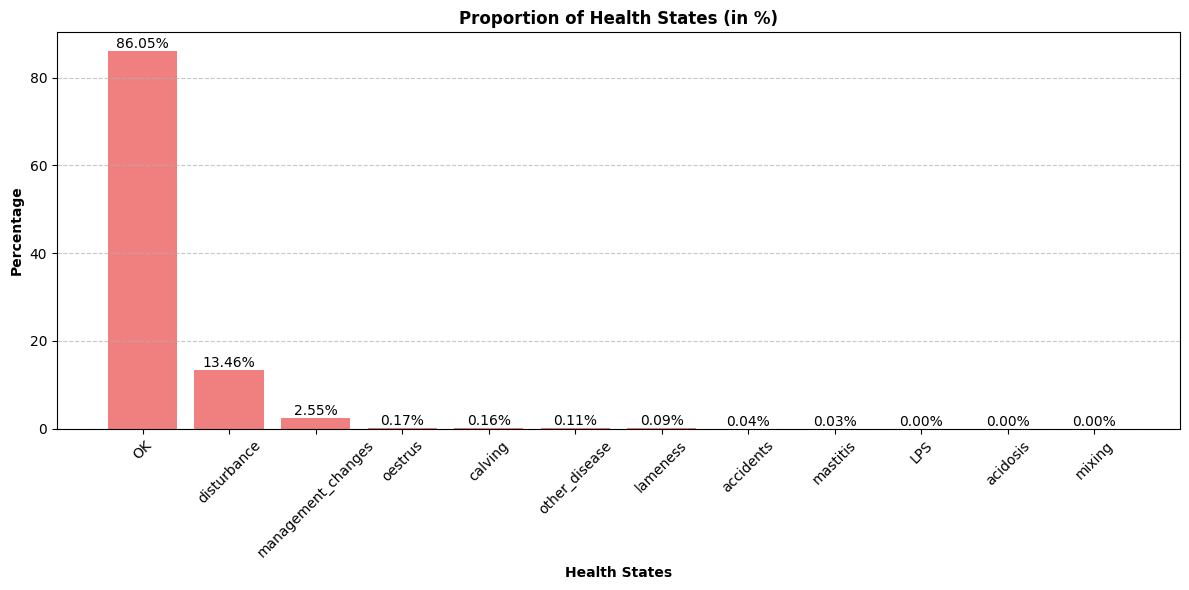


Missing Hours:


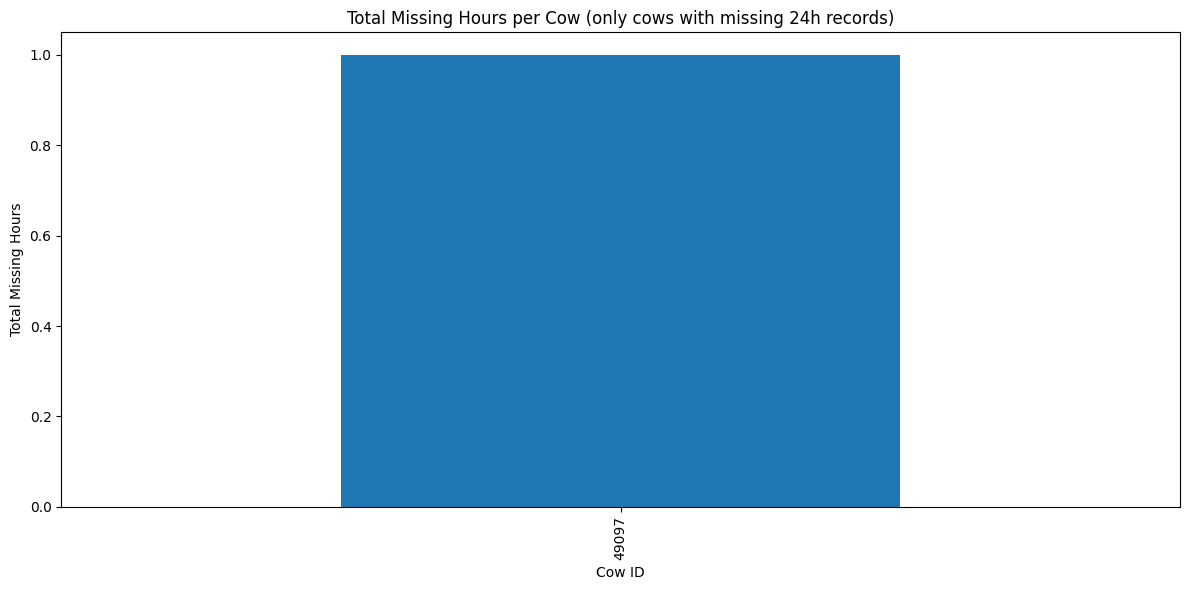


Date Range and Missing Dates:
Date range: 2014-12-01 00:00:00 to 2015-12-31 00:00:00
Total expected days: 396
Missing dates (2): 2015-07-05, 2015-07-06

Analysis of Cows with Multiple Diseases:
Number of cases with multiple diseases: 216

=== Summary Tables for All Datasets ===

Dataset Shape Summary:


,Dataset,Rows,Columns
0,dataset1.csv,107665,19
1,dataset2.csv,40247,19
2,dataset3.csv,26225,19
3,dataset4_truncated.csv,179759,19



Unique Cows and Missing Hours Summary:


,Dataset,Unique Cows,Cows with Missing Hours,Total Missing Hours
0,dataset1.csv,28,28,1079
1,dataset2.csv,28,1,1
2,dataset3.csv,30,12,79
3,dataset4_truncated.csv,25,1,1



Missing Values Summary:


,dataset1.csv,dataset2.csv,dataset3.csv,dataset4_truncated.csv
cow,0,0,0,0
date,0,0,0,0
hour,0,0,0,0
IN_ALLEYS,0,0,0,0
REST,0,0,0,0
EAT,0,0,0,0
ACTIVITY_LEVEL,0,0,0,0
oestrus,0,0,0,0
calving,0,0,0,0
lameness,0,0,0,0



Health States Distribution Summary:


,dataset1.csv,dataset2.csv,dataset3.csv,dataset4_truncated.csv
oestrus,0.91%,0.42%,2.38%,0.17%
calving,0.18%,0.00%,0.00%,0.16%
lameness,0.09%,0.95%,0.00%,0.09%
mastitis,0.20%,0.18%,0.00%,0.03%
LPS,0.60%,0.00%,0.00%,0.00%
acidosis,0.00%,16.16%,0.00%,0.00%
other_disease,0.22%,0.48%,0.00%,0.11%
accidents,0.00%,0.00%,0.00%,0.04%
disturbance,3.81%,40.01%,0.00%,13.46%
mixing,1.60%,0.00%,0.00%,0.00%


Note: Health states not present in a dataset are shown as 0.00%.

Outliers and Date Range Summary:


,Dataset,Outliers Count,Outliers %,Min Activity,Max Activity,Min Date,Max Date,Total Days,Missing Dates
0,dataset1.csv,0,0.00%,-828.00,1512.00,2018-10-25,2019-04-17,175,3
1,dataset2.csv,0,0.00%,-828.00,1512.00,2015-03-02,2015-04-30,60,0
2,dataset3.csv,0,0.00%,-828.00,1512.00,2013-10-01,2013-11-11,42,0
3,dataset4_truncated.csv,0,0.00%,-828.00,1512.00,2014-12-01,2015-12-31,396,2


In [21]:
datasets = [r"C:/Users/lamia/Desktop/datasets/dataset1.csv","C:/Users/lamia/Desktop/datasets/dataset2.csv","C:/Users/lamia/Desktop/datasets/dataset3.csv", "C:/Users/lamia/Desktop/datasets/dataset4_truncated.csv"]  

summary_data = []

for file_path in datasets:
    print(f"\nAnalyzing {file_path}")
    df = load_dataset(file_path)

    dataset_summary = {'name': file_path.split('/')[-1]}

    print("\nDataset First View:")
    display(display_dataset_head(df))

    print("\nDataset Rows & Columns count:")
    dataset_summary['shape'] = get_dataset_shape(df)
    print(f"Number of rows: {dataset_summary['shape']['rows']}")
    print(f"Number of columns: {dataset_summary['shape']['columns']}")

    print("\nColumn Names:")
    dataset_summary['columns'] = get_column_names(df)
    print(dataset_summary['columns'])

    behavioral_features, health_indicators = define_features(df)
    dataset_summary['behavioral_features'] = behavioral_features
    dataset_summary['health_indicators'] = health_indicators

    print("\nDistribution of Health States:")
    dataset_summary['health_distribution'] = get_health_states_distribution(df)
    plot_health_states_distribution(df)

    print("\nUnique Value Counts per Event:")
    dataset_summary['unique_value_counts'] = get_unique_value_counts(df)
    for col, counts in dataset_summary['unique_value_counts'].items():
        print(f"{col}:")
        print(counts)
        print("---------------------------------")

    print("\nNumber of Unique Cows:")
    dataset_summary['unique_cows'] = count_unique_cows(df)
    print(f"Total number of unique cows: {dataset_summary['unique_cows']}")

    print("\nCow IDs:")
    dataset_summary['cow_ids'] = get_cow_ids(df)
    print(f"Sorted list of cow IDs: {dataset_summary['cow_ids']}")

    print("\nDuplicate Values:")
    dataset_summary['duplicates'] = check_duplicates(df)
    print(f"Number of duplicated rows: {dataset_summary['duplicates']}")

    print("\nMissing Values:")
    dataset_summary['missing_values'] = check_missing_values(df)
    print(pd.Series(dataset_summary['missing_values']))

    print("\nMatrix of Missing Values:")
    plot_missing_values_matrix(file_path)

    print("\nOutliers Detection:")
    dataset_summary['outliers'] = detect_and_plot_outliers(df)
    print(f"Plage théorique : [-828, 1512]")
    print(f"Plage observée  : [{dataset_summary['outliers']['min_obs']:.2f}, {dataset_summary['outliers']['max_obs']:.2f}]")
    print(f"- Valeurs hors plage théorique : {dataset_summary['outliers']['num_outliers']} ({dataset_summary['outliers']['percent_outliers']:.2f}% du dataset)")

    print("\nData Distribution Histograms:")
    plot_histograms(df)

    print("\nHealth States Proportions:")
    plot_health_states_proportions(file_path)

    print("\nMissing Hours:")
    dataset_summary['missing_hours'] = get_missing_hours(file_path)

    print("\nDate Range and Missing Dates:")
    dataset_summary['date_range'] = check_date_range(df)
    print(f"Date range: {dataset_summary['date_range']['min_date']} to {dataset_summary['date_range']['max_date']}")
    print(f"Total expected days: {dataset_summary['date_range']['total_days']}")
    print(f"Missing dates ({dataset_summary['date_range']['missing_dates_count']}):", ', '.join(pd.date_range(start=dataset_summary['date_range']['min_date'], end=dataset_summary['date_range']['max_date'], freq='D').difference(df['date'].dt.date.unique()).strftime('%Y-%m-%d')))

    print("\nAnalysis of Cows with Multiple Diseases:")
    dataset_summary['multiple_diseases'] = analyze_multiple_diseases(df)
    print(f"Number of cases with multiple diseases: {dataset_summary['multiple_diseases']['multiple_disease_cases']}")

    summary_data.append(dataset_summary)

# Display summary tables
print("\n=== Summary Tables for All Datasets ===\n")
shape_df, cows_df, missing_df, health_df, outliers_df = create_summary_tables(summary_data)

print("Dataset Shape Summary:")
display(shape_df)

print("\nUnique Cows and Missing Hours Summary:")
display(cows_df)

print("\nMissing Values Summary:")
display(missing_df)

print("\nHealth States Distribution Summary:")
display(health_df)
print("Note: Health states not present in a dataset are shown as 0.00%.")

print("\nOutliers and Date Range Summary:")
display(outliers_df)